## Log Likelihood Example

# Problem
There is an experiment to measure LED characteristics. The experiment setup consists of LEDs put into a dark box and each LED is pulsed such that only a small amount of light is released. At the other end of the box is a photon detector, each photon deposits 1 pC of charge in the detector. This measured charge is recorded for later analysis.

For this experiment there were three different LEDs configurations tested. Each LED has a different characteristic number of photons released in each pulse. Two of these setups had a single LED pulsed 10,000 times. In the third setup, two LEDs were pulsed, each 5,000 times, for a total of 10,000 measurements. The three different experiments output data are stored in the files, expta.dat, exptab.dat, and exptac.dat.

We are tasked with measuring the expected number of photons for each LED and give the error on that measurement. In addition, we need to determine which of the three experimental setups had single LEDs and which had two LEDs.

# Solution
To measure the LED properties, we need to take two steps. First, identify which of the two datasets correspond to the single LED setups. This will be accomplished by performing a simple $\chi^2$ fit assuming the single LED configuration and comparing the $\chi^2$ values to find the outlier. Second, a fit using a maximum likelihood method will be employed, this will allow for an error estimation of the expected photons per pulse for each LED.


# Probability Distributions
The number of photons output by the LEDs follows a poisson distribution, $P(k)  = \frac{\mu^k e^{-\mu}}{k!}$, where k is the number of photos released, and $\mu$ is the expected number of photos released. This $\mu$ is different for each of the LEDs and is the value to be measured.

The photon detector has a gaussian error on the measured charge. The sigma of this error has two factors, a constant of 0.08 pC and an error proportional to the square root of the number, n, of photons detected with a constant of 0.10 pC. Combining these errors in quadrature, the total gaussian error is $\sigma = \sqrt{(0.08 pC)^2 + n \times (0.10 pC)^2}$.

Combining the photon detector and LED distibutions, you obtain a PDF for the measured charge C for the single LED:


$P(C, \mu) = \sum_{k=0}^{\infty} \frac{\mu^k e^{-\mu}}{k!} \times \frac{1}{\sqrt{2 \pi \sigma (k)}} \times e^{\frac{-(C - k)^2}{2 \sigma(k)^2}}$

$\sigma(k) = \sqrt{(0.08 pC)^2 + n \times (0.10 pC)^2}$

For the two LED configuration, the probability distribution is a sum of two single LED probabilities

$P(C, \mu_1, \mu_2) = 0.5 \times P(C, \mu_1) + 0.5 \times P(C, \mu_2)$

In [1]:
import numpy as np
from scipy.special import factorial
from scipy.stats import poisson
import matplotlib.pyplot as plt
import UsefulFuncs
from scipy.optimize import minimize
from scipy import stats

plt.rcParams.update({'font.size': 18})

%matplotlib inline

In [2]:
def GaussianSigma(n):
    return np.sqrt(0.08**2 + n * 0.10**2)

def GaussianFunc(C, k):
    return 1./(np.sqrt(2 * np.pi* GaussianSigma(k)**2)) * np.exp( -(C - k)**2 / (2 * GaussianSigma(k)**2))
    
def ChargeProb(data,mu):
    k = np.arange(0,50)
    x, y = np.meshgrid(data,k)
    return np.sum(GaussianFunc(x,y)*poisson.pmf(y,mu),axis=0)

def ChargeProb2LED(data,mu1,mu2):
    k = np.arange(0,50)
    x, y = np.meshgrid(data,k)
    return 0.5*(np.sum(GaussianFunc(x,y)*poisson.pmf(y,mu1),axis=0) + np.sum(GaussianFunc(x,y)*poisson.pmf(y,mu2),axis=0))

# First Fitting

Because there are two different types of configurations, one with single LEDs and one with two LEDs, a simple fitting and KS test should tell us which of the two configurations each file corresponds to. The simple fitting will be performed by minimizing the Chi-squared value,

$\chi^2 = \sum_{i} \frac{(x_i - m_i)^2}{m_i}$,

where $x_i$ is the observed value in the $i$th bin, and $m_i$ is the expected value in the $i$th bin. The expected value is,

$m_i = \int_{i} P(C) dC$,

with the integration bounds being the bin edges. This will be approximated by a Riemann sum,

$\int_{x_{i-1}}^{x_i} f(x)dx = \sum \frac{(f(x_{i-1}) + f(x_i))(x_{i-1}-x_i)}{2}$.

This first fitting will provide a best fit $\mu$, which can then be put into a KS test to test the compability between the data and the single LED model.

In [5]:
def Minimumizationthingy(mu,data,bins):
    return UsefulFuncs.Chi2(data,100000*UsefulFuncs.RiemannSum(ChargeProb(bins,mu),bins))

In [3]:
da = np.genfromtxt('expta.dat')
db = np.genfromtxt('exptb.dat')
dc = np.genfromtxt('exptc.dat')

In [4]:
bins = np.linspace(-1,50,500)

valuea, ea = UsefulFuncs.BinIt(da, bins = bins, weight = np.ones(len(da)))
valueb, eb = UsefulFuncs.BinIt(db, bins = bins, weight = np.ones(len(db)))
valuec, ec = UsefulFuncs.BinIt(dc, bins = bins, weight = np.ones(len(dc)))

In [6]:
fita = minimize(Minimumizationthingy,x0=1,args=(valuea,bins),method = 'Nelder-Mead')
fitb = minimize(Minimumizationthingy,x0=1,args=(valueb,bins),method = 'Nelder-Mead')
fitc = minimize(Minimumizationthingy,x0=1,args=(valuec,bins),method = 'Nelder-Mead')

print "Chi-squared values: ", fita['fun'], fitb['fun'], fitc['fun']

Chi-squared values:  954.442127461109 437.14513374493424 102139.60321486731


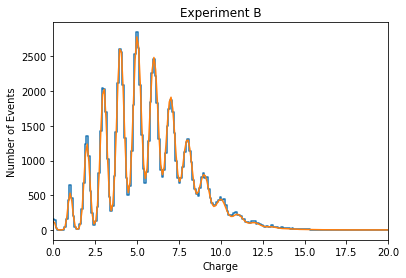

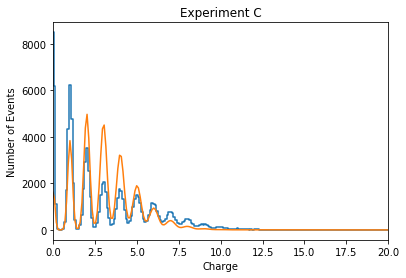

In [7]:
x, y = UsefulFuncs.steppedBins(valueb,bins)

plt.plot(x,y)
plt.plot((bins[1:]+bins[:-1])/2, 100000*UsefulFuncs.RiemannSum(ChargeProb(bins,fitb['x']),bins))
plt.title('Experiment B')
plt.xlabel('Charge')
plt.ylabel('Number of Events')
plt.xlim(0,20)
plt.show()

x, y = UsefulFuncs.steppedBins(valuec,bins)

plt.plot(x,y)
plt.plot((bins[1:]+bins[:-1])/2, 100000*UsefulFuncs.RiemannSum(ChargeProb(bins,fitc['x']),bins))
plt.title('Experiment C')
plt.xlabel('Charge')
plt.ylabel('Number of Events')
plt.xlim(0,20)
plt.show()

# First Fitting results
Experiment c is clearly the experiment where two LEDs were used. It has a much larger $\chi^2$ value and the best fit model has an obvious mismatch compared to experiment B. Now the different experiments setups are established, an unbinned maximum likelihood fit will be performed.

# Maximum Likelihood Fitting
Likelihood is a measure how likely a dataset is from a model. 

$\mathcal{L}(x_1 ... x_N | \mu) = \prod_{n=1}^N P(x_n, \mu)$

where $x_i$ is the nth charge in the dataset. This product is performed over the entire dataset. It is common to calculate the negative log likelihood and minimize that, as it envolves sums instead of products.

$-log(\mathcal{L}(x_1 ... x_N | \mu)) = -\sum_{n=1}^N log(P(x_n, \mu))$

The one sigma error bounds of $\mu$ are the values of $\mu$ that increase $-log(\mathcal{L})$ by 0.5 from the minimum.

In [8]:
def LogLikelihood1LED(mu,data):
    return -np.sum(np.log(ChargeProb(data,mu)))

def LogLikelihood2LED(mu,data):
    return -np.sum(np.log(ChargeProb2LED(data,mu[0],mu[1])))

In [9]:
LLHa = minimize(LogLikelihood1LED,x0=fita['x'],args=(da),method = 'Nelder-Mead')
LLHb = minimize(LogLikelihood1LED,x0=fitb['x'],args=(db),method = 'Nelder-Mead')
LLHc = minimize(LogLikelihood2LED,x0=(fitc['x'],fitc['x']),args=(dc),method = 'Nelder-Mead')

In [10]:
print "Best fit mu's from maximum likelihood: ", LLHa['x'], LLHb['x'], LLHc['x']
print "Best fit mu's from Chi^2 fit: ", fita['x'], fitb['x'], fitc['x']

Best fit mu's from maximum likelihood:  [1.45588951] [5.76321402] [5.02153462 1.00690219]
Best fit mu's from Chi^2 fit:  [1.45234375] [5.76884766] [3.19616699]


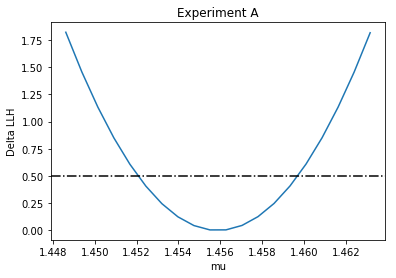

In [11]:
mua = np.linspace(LLHa['x']*0.995,LLHa['x']*1.005,20)
muaLLh = np.zeros(len(mua))
for i in range(len(mua)):
    muaLLh[i] = LogLikelihood1LED(mua[i],da)-LLHa['fun']
plt.plot(mua,muaLLh)
plt.xlabel('mu')
plt.ylabel('Delta LLH')
plt.title('Experiment A')
plt.axhline(0.5,color='black',ls='-.')
plt.show()

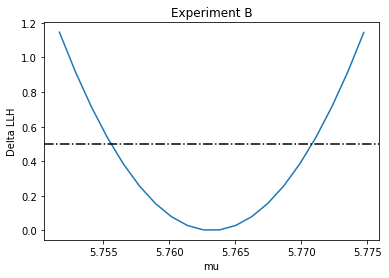

In [12]:
mub = np.linspace(LLHb['x']*0.998,LLHb['x']*1.002,20)
mubLLh = np.zeros(len(mub))
for i in range(len(mub)):
    mubLLh[i] = LogLikelihood1LED(mub[i],db)-LLHb['fun']
plt.plot(mub,mubLLh)
plt.xlabel('mu')
plt.ylabel('Delta LLH')
plt.title('Experiment B')
plt.axhline(0.5,color='black',ls='-.')
plt.show()

# 1D Results
For experiment A and B, the best fit mu values were 1.456 +- 0.004 and  5.763 +- 0.007 respectively. For experiemnt C, the best fit mu values were 5.02 and 1.01, the 2D contour plot showing the delta LLH is shown below. In the 2D LLH case, the value of 0.5 corresponds to the 39% confidence interval.

In [13]:
muc1 = np.linspace(LLHc['x'][0]*0.995,LLHc['x'][0]*1.005,20)
muc2 = np.linspace(LLHc['x'][1]*0.99,LLHc['x'][1]*1.01,20)

mucLLh = np.zeros((len(muc1)-1,len(muc2)-1))
for i in range(len(muc1)-1):
    for j in range(len(muc2)-1):
        mucLLh[i,j] = LogLikelihood2LED(((muc1[i]+muc1[i+1])/2,(muc2[j]+muc2[j+1])/2),dc)-LLHc['fun']

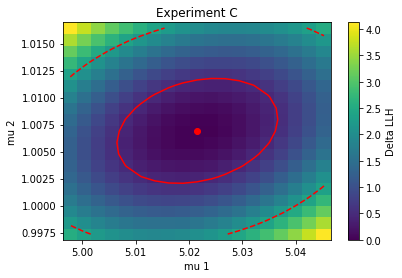

In [42]:
X, Y = np.meshgrid(muc1,muc2)

plt.pcolormesh(X, Y, mucLLh,cmap='viridis')
cb = plt.colorbar()
cb.set_label('Delta LLH')
plt.xlabel('mu 1')
plt.ylabel('mu 2')
plt.title("Experiment C")
plt.contour((muc1[:-1]+muc1[1:])/2, (muc2[:-1]+muc2[1:])/2, mucLLh, [0.5,2.3],
            colors=['red'],linestyles =['solid','dashed'])
plt.scatter(LLHc['x'][0],LLHc['x'][1],color='red')
plt.show()

# 2D Results
While the procedure for interpreting the results of the 2D likelihood scan is the same as for 1D, the confidence interval values change, as the measured values follow a 2D gaussian distribution instead of a 1D gaussian. The red marker shows the best fit value, the solid red contour is the 39% confidence interval, and the dashed red contour is the 90% confidence interval.